# Evaluating the calibration of a DL model

In [83]:
from typing import Tuple, Optional #, List, Union
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler#,StandardScaler
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras import losses, layers

In [2]:
# To ensure reproducible results (as much as possible)
seed = 1218
tf.keras.utils.set_random_seed(seed)

### Overview

The homework concerns training and evaluating the calibration of a neural network. It is divided into a small series of exercises: **the maximum mark (for the purpose of the exam) is 5**, but the total sum of points is 5.5, so you are allowed a margin of error. **Completing succesfully everything will result in a mark of 5+**.

🟥 The homework must be completed *using TensorFlow*. Do not use NumPy or anything else (with one exception in Exercise 5).

Below a brief description of the exercises; please read everything carefully at least once.

1.   **Exercise 1** (1 point): training a neural network on the provided dataset.
2.   **Exercise 2 and 3** (2 points): draw a *confidence histogram* and a *reliability diagram* (see instructions).
3.   **Exercise 4** (0.5 points): compute the *expected calibration error* (ECE).
3.   **Exercise 5** (1 point): implement the *multi-class focal loss* and re-check calibration.
4.   **Exercise 6** (1 point): implement a simple *conformal prediction* (CP) strategy (see instructions below).





## Data loading

The dataset we use is a well-known toy multiclass dataset concerning wine quality: https://archive.ics.uci.edu/ml/datasets/wine+Quality

We preprocess the original quality index into three classes (low, medium, and high quality), similarly to this notebook that you can check for more information about the dataset: https://www.kaggle.com/code/mgmarques/wines-type-and-quality-classification-exercises

In [3]:
!wget --quiet https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

In [3]:
def load_data(dataset: str) -> pd.DataFrame:
    """ Load the dataset.
    Returns:
        data (pd.DataFrame): dataset with adjusted columns.
    """

    data = pd.read_csv(dataset, sep=';')
    data['quality'] = data.quality.apply(lambda q: 0 if q <= 5 else 1 if q <= 7 else 2) # Choose a different categorization as suggested by dataset authors
    qual = {0:"low", 1:"medium", 2:"high"}
    data["quality_cat"] = data.quality.apply(lambda x: qual[x]) # For plots
    return data

In [4]:
data = load_data('winequality-white.csv')
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_cat
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,1,medium
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,1,medium
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,1,medium
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,1,medium
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,1,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,1,medium
4894,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,0,low
4895,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,1,medium
4896,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,1,medium


We can easly visualize that we are dealing with an imnbalanced dataset

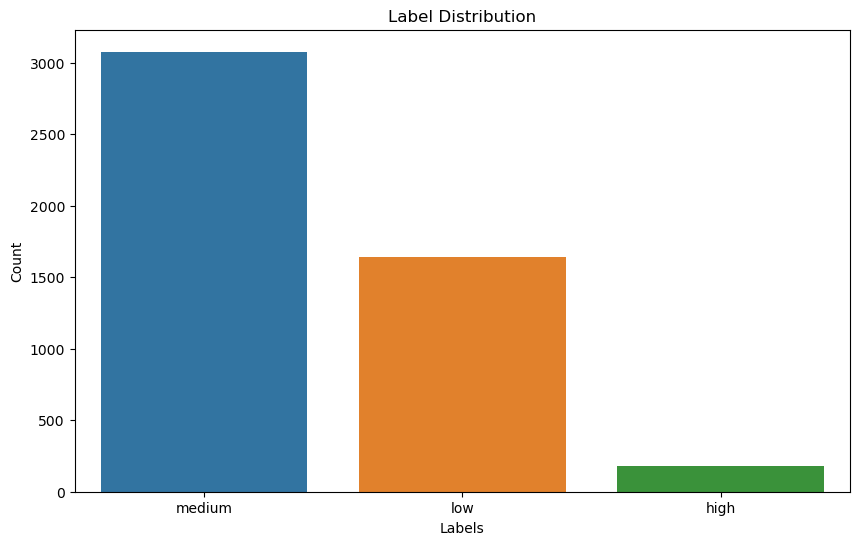

In [5]:
# This is highly unbalanced by default
plt.figure(figsize=(10, 6))
sns.countplot(x='quality_cat', data=data)
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [6]:
def preprocessing(data: pd.DataFrame,
                  seed: int = 1218) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Applies some preprocessing such as NAs imputation, features scaling, resampling observations using a SMOTE algorithm
    to the given dataset. Then splits it into training and testing sets.

    Args:
        data (pd.DataFrame): dataset with features and labels.
        seed (int): Random seed for reproducibility. Default is 1218.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]: Resampled and split training and testing feature sets and target values.
    """

    # Remove NAs
    data = data.dropna()
    # Take values from dataset and divide covariates from labels
    del data["quality_cat"] # we no more need this attribute
    X, y = data.values[:, :-1], data.values[:, -1]
    # Scale
    scaler = RobustScaler()
    X = scaler.fit_transform(X) # Normalize (we are "cheating" by also using the test data)
    # Resampling
    sm = SMOTE(random_state=seed)
    X, y = sm.fit_resample(X, y)
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

    return tf.constant(X_train), tf.constant(X_test), tf.constant(y_train), tf.constant(y_test)

In [7]:
X_train, X_test, y_train, y_test = preprocessing(data, seed)

In [9]:
# class DatasetBuilder:
#     """
#     A class to build a TensorFlow dataset for training machine learning models.

#     Attributes:
#         X (tf.Tensor): Features for the dataset.
#         y (tf.Tensor): Labels for the dataset.
#         batch_size (int): The size of each batch.
#         shuffle (bool): Whether to shuffle the dataset.
#         shuffle_buffer_size (int): Number of elements from this dataset from which the new dataset will sample.

#     Methods:
#         build(): Constructs and returns the TensorFlow dataset.
#     """

#     def __init__(self, X: tf.Tensor, y: tf.Tensor,
#                  shuffle: bool = False, shuffle_buffer_size: Optional[int] = None) -> None:
#         """
#         Initializes the DatasetBuilder with data and configuration.

#         Args:
#             X (tf.Tensor): Input features.
#             y (tf.Tensor): Input labels.
#             batch_size (int, optional): Size of each batch. Defaults to 32.
#             shuffle (bool, optional): Whether to shuffle the data. Defaults to True.
#             shuffle_buffer_size (int, optional): Buffer size for shuffling. Defaults to the size of X if not provided.
#         """
#         self.X = X
#         self.y = y
#         self.shuffle = shuffle
#         self.shuffle_buffer_size = shuffle_buffer_size or len(X)

#     @tf.function
#     def build(self) -> tf.data.Dataset:
#         """
#         Constructs and returns the TensorFlow dataset.

#         Returns:
#             tf.data.Dataset: The prepared TensorFlow dataset.
#         """
#         dataset = tf.data.Dataset.from_tensor_slices((self.X, self.y))

#         if self.shuffle:
#             dataset = dataset.shuffle(self.shuffle_buffer_size)

#         dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

#         return dataset

In [10]:
# train_builder = DatasetBuilder(X_train, y_train)
# test_builder = DatasetBuilder(X_test, y_test)
# train_data = train_builder.build()
# test_data = test_builder.build()

In [8]:
# Baseline accuracy
from sklearn.dummy import DummyClassifier
DummyClassifier().fit(X_train, y_train).score(X_test, y_test)

0.31961888263317456

## Train a neural network model

Define, train, and test a neural network for the provided dataset.

☝ You are free to make any modelling choice (e.g., activation function), provided the result makes sense.

✅ **Completion requirement**: print on screen the test accuracy of the network. Comments are appreciated.

In [12]:
# class DenseBlock(tf.keras.layers.Layer):
#     def __init__(self, depth):
#         super(DenseBlock, self).__init__()
#         self.dense_layers = Sequential([Dense(2 ** (depth - i + 1), activation="gelu") for i in range(depth-1)])

#     def call(self, inputs):
#         x = inputs
#         return self.dense_layers(x)


# class MyDenseNet(tf.keras.Model):
#     def __init__(self, depth, input_shape, output_shape):
#         super(MyDenseNet, self).__init__()
#         self.depth = depth
#         self.first_layer = Dense(2**(self.depth+2), input_shape=(input_shape,), activation="gelu")
#         self.dense_block = DenseBlock(self.depth-1)
#         self.output_layer = Dense(output_shape, activation='softmax')

#     @tf.function
#     def call(self, inputs):
#         x = self.first_layer(inputs)
#         x = self.dense_block(x)
#         return self.output_layer(x)

#
#     def get_depth(self):
#         # Do not count the output layer
#         return self.depth

#
#     def maximum_width(self):
#         return max(layer.units for layer in self.layers_list)

In [9]:
class MyDenseNet(tf.keras.Model):
    def __init__(self, depth, input_shape, output_shape):
        super(MyDenseNet, self).__init__()
        self.depth = depth
        self.dense_block = tf.keras.Sequential([layers.Dense(2**(self.depth+2), input_shape=(input_shape,), activation="gelu")])
        for i in range(depth-2):
            self.dense_block.add(layers.Dense(2 ** (depth - i + 1), activation="gelu"))
        self.dense_block.add(layers.Dense(output_shape, activation='softmax'))

    def call(self, inputs):
        x = self.dense_block(inputs)
        return x

In [10]:
# Define hyperparameters
EPOCHS = 60
BATCH_SIZE = 64
INPUT_SHAPE = X_train.shape[1]
NUM_CLASSES = np.unique(y_train).shape[0]

# Define the loss
loss_func = losses.SparseCategoricalCrossentropy()

In [11]:
# Build the models for different depths
models = {}
for i in range(10):
    DEPTH = i
    models[i] = MyDenseNet(DEPTH, INPUT_SHAPE, NUM_CLASSES)

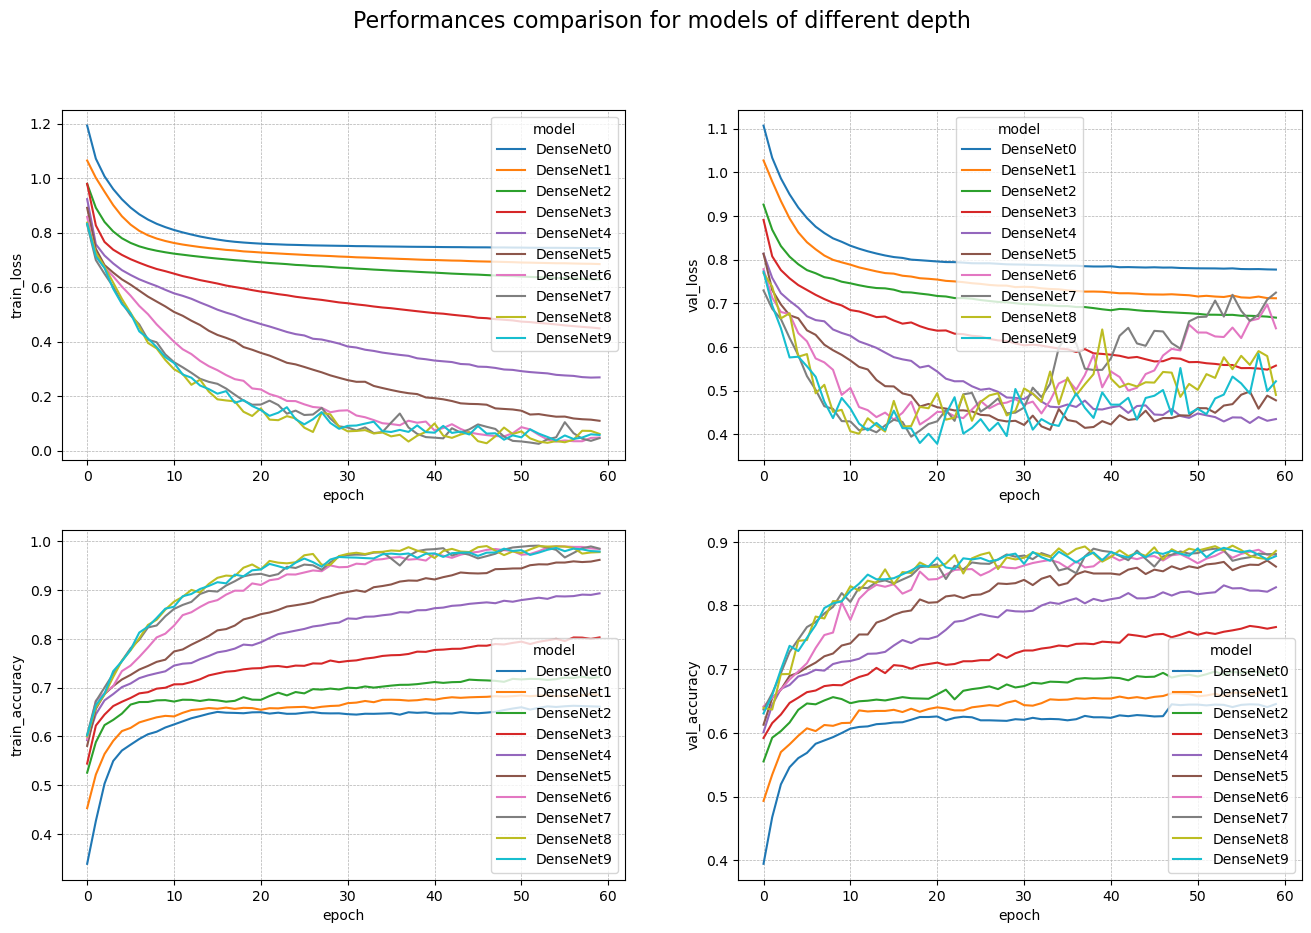

In [12]:
# Save the models through checkpoints to avoid massive computation
PATH = os.getcwd() + "/models"

metrics = pd.DataFrame()
for i,model in enumerate(models.values()):
    # We use the same metric, same optimizer and same loss for each model
    model.compile(optimizer='adam',
                loss=loss_func,
                metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=False)

    # Checkpoint the model's weights
    model.save_weights(f'{PATH}/DenseNet{i}/DenseNet{i}_weights')

    # Save the model's history in a DataFrame
    temp = pd.DataFrame({
        "train_accuracy": history.history["accuracy"],
        "val_accuracy": history.history["val_accuracy"],
        "val_loss": history.history["val_loss"],
        "train_loss": history.history["loss"],
        "epoch": np.arange(0, EPOCHS),
        "model": f'DenseNet{i}'
    })

    metrics = pd.concat([metrics, temp])

# Plotting time
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
# Plot losses
sns.lineplot(data=metrics, x="epoch", y="train_loss", hue="model", ax=axs[0,0])
sns.lineplot(data=metrics, x="epoch", y="val_loss", hue="model", ax=axs[0,1])
# Plot accuracy scores
sns.lineplot(data=metrics, x="epoch", y="train_accuracy", hue="model", ax=axs[1,0])
sns.lineplot(data=metrics, x="epoch", y="val_accuracy", hue="model", ax=axs[1,1])

# Add a dotted grid to each subplot
for ax in axs.flatten():
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

fig.suptitle("Performances comparison for models of different depth", fontsize=16)
plt.show()

In [13]:
# Load the checkpoints and get ready for the rest of the notebook
for i, model in enumerate(models.values()):
    model.compile(optimizer='adam',
                loss=loss_func,
                metrics=['accuracy'])
    model.load_weights(f'{PATH}/DenseNet{i}/DenseNet{i}_weights')

### Exercise 2: Confidence histogram of the network (1 point)

🟥 Before starting, read carefully at least Sections 1 and 2 of the following paper: [On the calibration of modern neural networks](https://arxiv.org/abs/1706.04599) (which we also discussed in class). We will refer to the paper as (Guo et al., 2017).

The purpose of this exercise is to replicate a confidence histogram *computed over the test set*, which is Fig. 1 in (Guo et al., 2017), top-left figure. The plot should include:
1. The distribution of the network's confidence (corresponding to **the highest output probability**);
2. The average accuracy of the network;
3. The average confidence of the network.

✅ **Completion requirement**: plot the correct figure. Please include a readable legend and captions on the axes.

In [14]:
# TODO: plot the confidence histogram.

def plot_confidence_histograms(models, X_test, y_test, n_bins=30):
    """
    Plots a histogram of confidence scores for the model predictions on the test data.

    Args:
    model: The trained TensorFlow model.
    test_data: Test dataset (features).
    """
    fig, axs = plt.subplots(4,3, figsize=(15, 16))
    axs = axs.flatten()

    for i, model in enumerate(models.values()):
        n = i
        predictions = model.predict(X_test, verbose=False)
        confidences = np.max(predictions, 1)
        counts, bins = np.histogram(confidences, n_bins)
        precentages = counts/len(confidences)

        avg_conf = np.mean(confidences)
        metric = SparseCategoricalAccuracy()
        metric.update_state(y_test, predictions, sample_weight=None)
        acc = metric.result().numpy()

        # to center the last plot
        if i==9:
            i=10
        axs[i].stairs(precentages, bins, fill=True, color="skyblue")

        axs[i].axvline(acc, color='indigo', linestyle='dashed', linewidth=2, label='Accuracy')
        axs[i].axvline(avg_conf, color='blue', linestyle='dashed', linewidth=2, label='Average Confidence')
        if acc < avg_conf:
            a_pos = acc-0.01
            c_pos = avg_conf+0.038
        else:
            c_pos = avg_conf-0.01
            a_pos = acc+0.038
        y_max = axs[i].get_ylim()[1]
        axs[i].text(a_pos, y_max*0.62, f' Accuracy: {acc:.2f}', color='indigo', ha='right', rotation=90)
        axs[i].text(c_pos, y_max*0.45, f' Avg. Confidence: {avg_conf:.2f}', color='blue', ha='right', rotation=90)

        axs[i].grid(which='both', linestyle='--', linewidth=0.5)
        axs[i].set_title(f'Number of hidden layers: {n}')
        axs[i].set_xlabel('Confidence score')
        axs[i].set_ylabel('% of samples')

    axs[-3].remove()
    axs[-1].remove()

    fig.suptitle("Confidence Histograms for models of different depth", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.show()

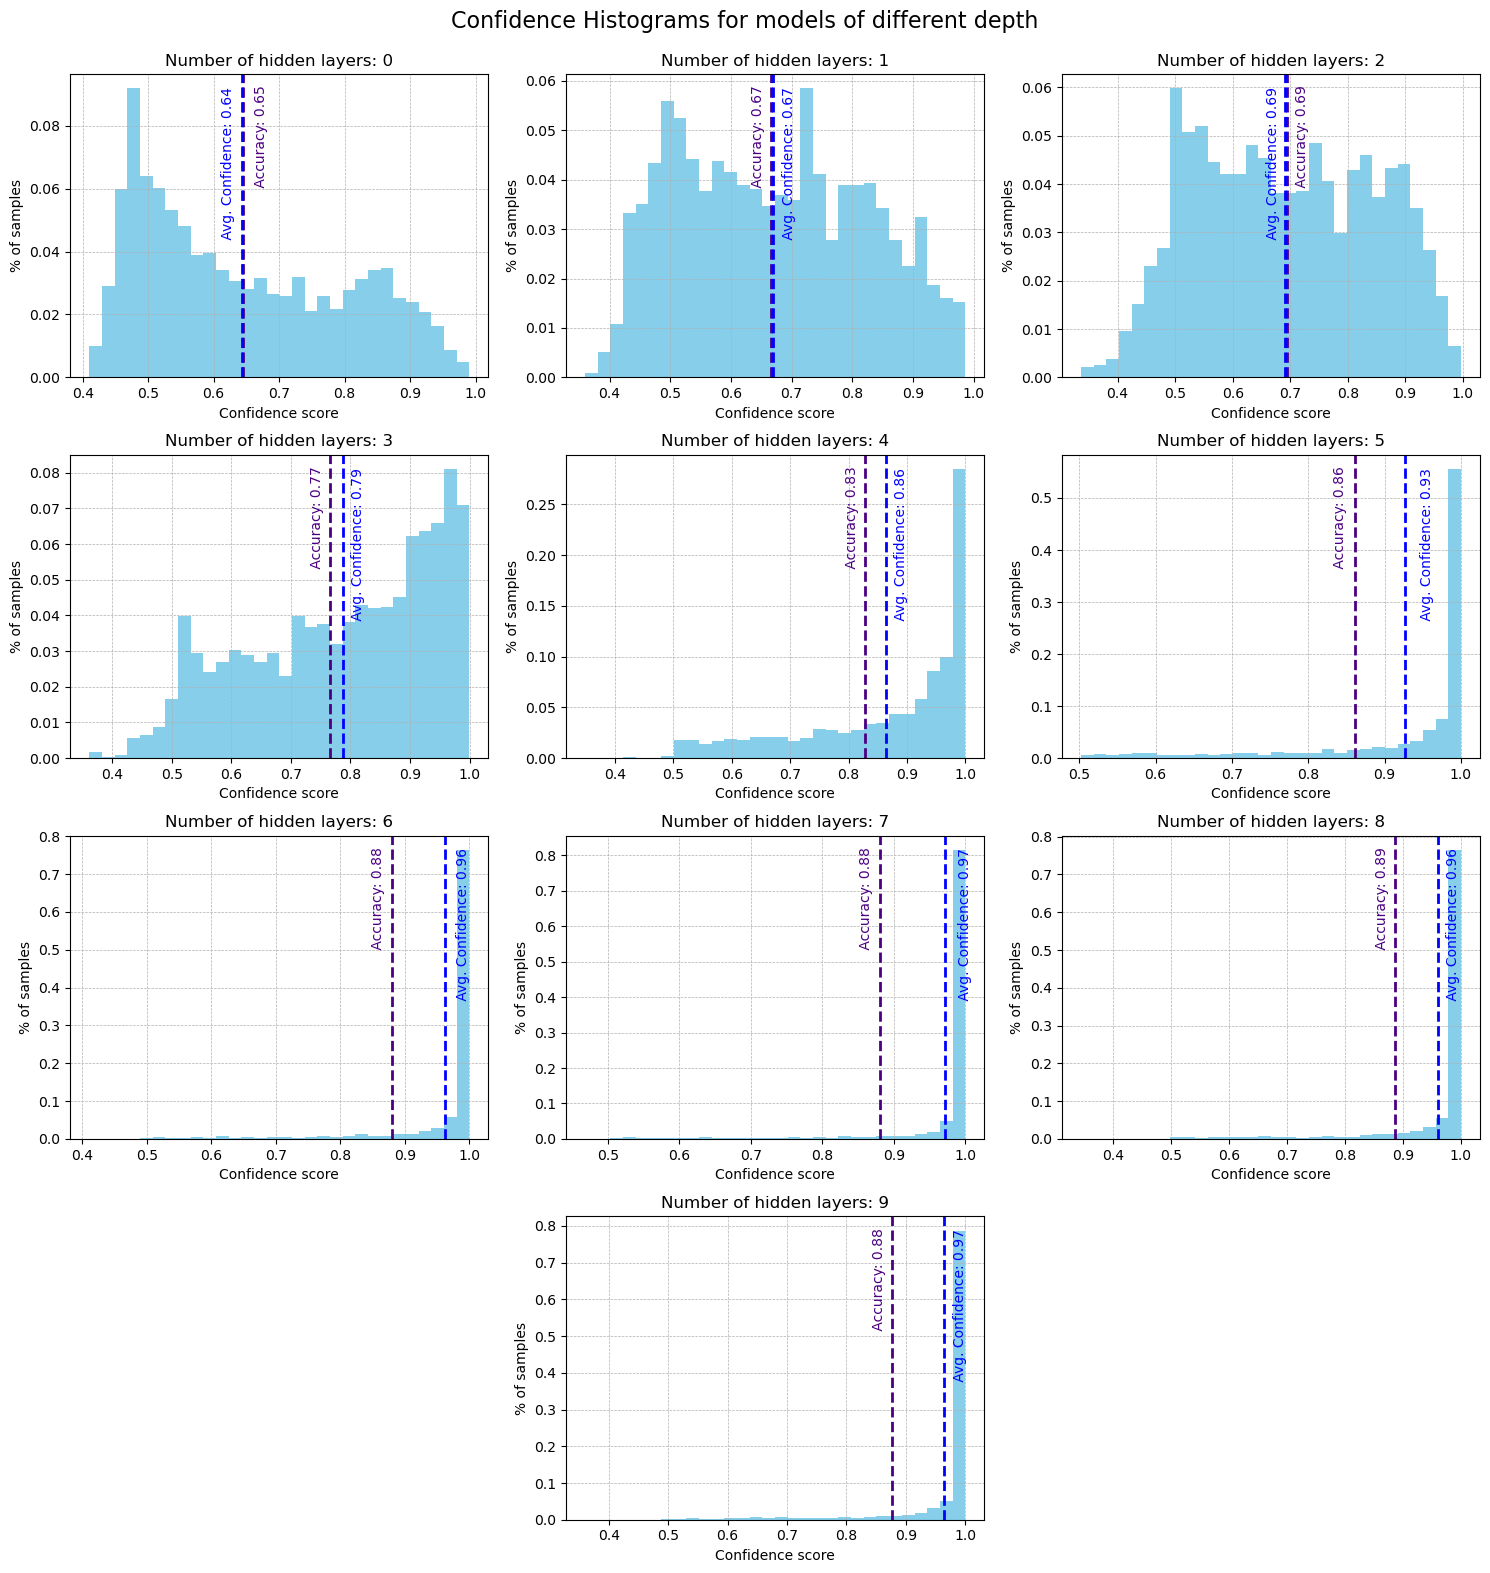

In [15]:
plot_confidence_histograms(models, X_test, y_test, 30)

### Exercise 3: Reliability diagrams (1 point)

This is similar to exercise 2, but you need to plot a **reliability diagram**, which is the bottom-left figure in Fig. 1 from (Guo et al., 2017). For this figure you need:

1. The histogram of the average accuracy of the network for each bin.
2. A superimposed histogram of the average confidence for each bin.
3. A diagonal line showing perfect calibration.

☝ **Hint**: the `Discretization` layer from TF may be useful: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Discretization

🟩 **Completion requirement**: plot the correct figure. Please include a readable legend and captions on the axes.


In [105]:
def plot_reliability_diagrams(models, X_test, y_test, n_bins=10):
    """

    Args:
    model: The trained TensorFlow model.
    test_data: Test dataset (features).
    """
    # Setup bin boundaries given the numb of bins
    bin_boundaries = tf.linspace(start=0.0, stop=1.0, num=n_bins)
    # Build function for confidences binnin
    # bin_map = layers.Discretization(bin_boundaries=bin_boundaries, output_mode='int')

    fig, axs = plt.subplots(4,3, figsize=(15, 16))
    axs = axs.flatten()

    for i, model in enumerate(models.values()):
        n = i
        predictions = model.predict(X_test, verbose=False)
        confidences = np.max(predictions, 1)
        # Take the indeces to map from confidences to classes
        class_preds = np.argmax(predictions, axis=1)
        # Create the bins of confidences
        binned_confidences = np.digitize(confidences, bin_boundaries, right=True)

        acc = []
        avg_conf = []
        # Iterate over the bins
        for k in range(n_bins):
            # Take indices in the k-th confidence bin
            idxs = np.nonzero(binned_confidences==k)[0]
            bin_card = len(idxs)
            # If no prediction confidence in this bin set metrics to 0
            if bin_card == 0:
                acc.append(0)
                avg_conf.append(0)
            else:
                bin_preds = class_preds[idxs]
                bin_true_labels = y_test.numpy()[idxs]
                bin_acc = np.array(bin_true_labels == bin_preds, dtype=int)
                bin_confs = confidences[idxs]
                acc.append(sum(bin_acc)/bin_card)
                avg_conf.append(sum(bin_confs)/bin_card)
        

        # Conversion to array to leverage broadcasting ops
        acc = np.array(acc)
        avg_conf = np.array(avg_conf)

        # Compute the ECE
        ECE = np.sum(np.abs(acc-avg_conf)*bin_card/len(y_test))

        # to center the last plot
        if i==9:
            i=10
        
        overconfident = avg_conf > acc
        underconfident = avg_conf < acc

        # Fill region between model's reliability diagram and identity function
        axs[i].fill_between(avg_conf, acc, avg_conf, where=underconfident, interpolate=True, color='skyblue', alpha=0.5)
        axs[i].fill_between(avg_conf, acc, avg_conf, where=overconfident, interpolate=True, color='salmon', alpha=0.5)

        # Plotting time
        sns.lineplot(y=acc, x=avg_conf, color='orangered', label=r'$P(\hat{Y}=Y|\hat{P}=P)$', ax=axs[i])
        axs[i].plot([0, 1], [0, 1], color='grey', linestyle='--')
        axs[i].set_ylim(0,1.)
        axs[i].set_xlim(0)
        axs[i].grid(which='both', linestyle='--', linewidth=0.5)
        axs[i].set_title(f'Number of hidden layers: {n}')
        axs[i].set_xlabel('Confidence')
        axs[i].set_ylabel('Accuracy')
        # Add a text box for ECE
        ece_text = f'ECE: {ECE:.2f}'
        axs[i].text(0.95, 0.05, ece_text, verticalalignment='bottom', horizontalalignment='right', transform=axs[i].transAxes, color='blue', fontsize=12)


        overconfident_patch = mpatches.Patch(color='salmon', alpha=0.5, label='Overconfident Gap')
        underconfident_patch = mpatches.Patch(color='skyblue', alpha=0.5, label='Underconfident Gap')

        # Custom handles to the legend along with the existing ones
        handles, _ = axs[i].get_legend_handles_labels()
        handles.extend([overconfident_patch, underconfident_patch])
        axs[i].legend(handles=handles, loc='upper left')

        if (i % 3 != 0) and (i!=10):
            axs[i].set_ylabel('')
            axs[i].set_yticklabels([])
        if i not in [6,8,10]:
            axs[i].set_xlabel('')

    axs[-3].remove()
    axs[-1].remove()
    fig.suptitle("Reliability diagrams for models of different depth", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.show()

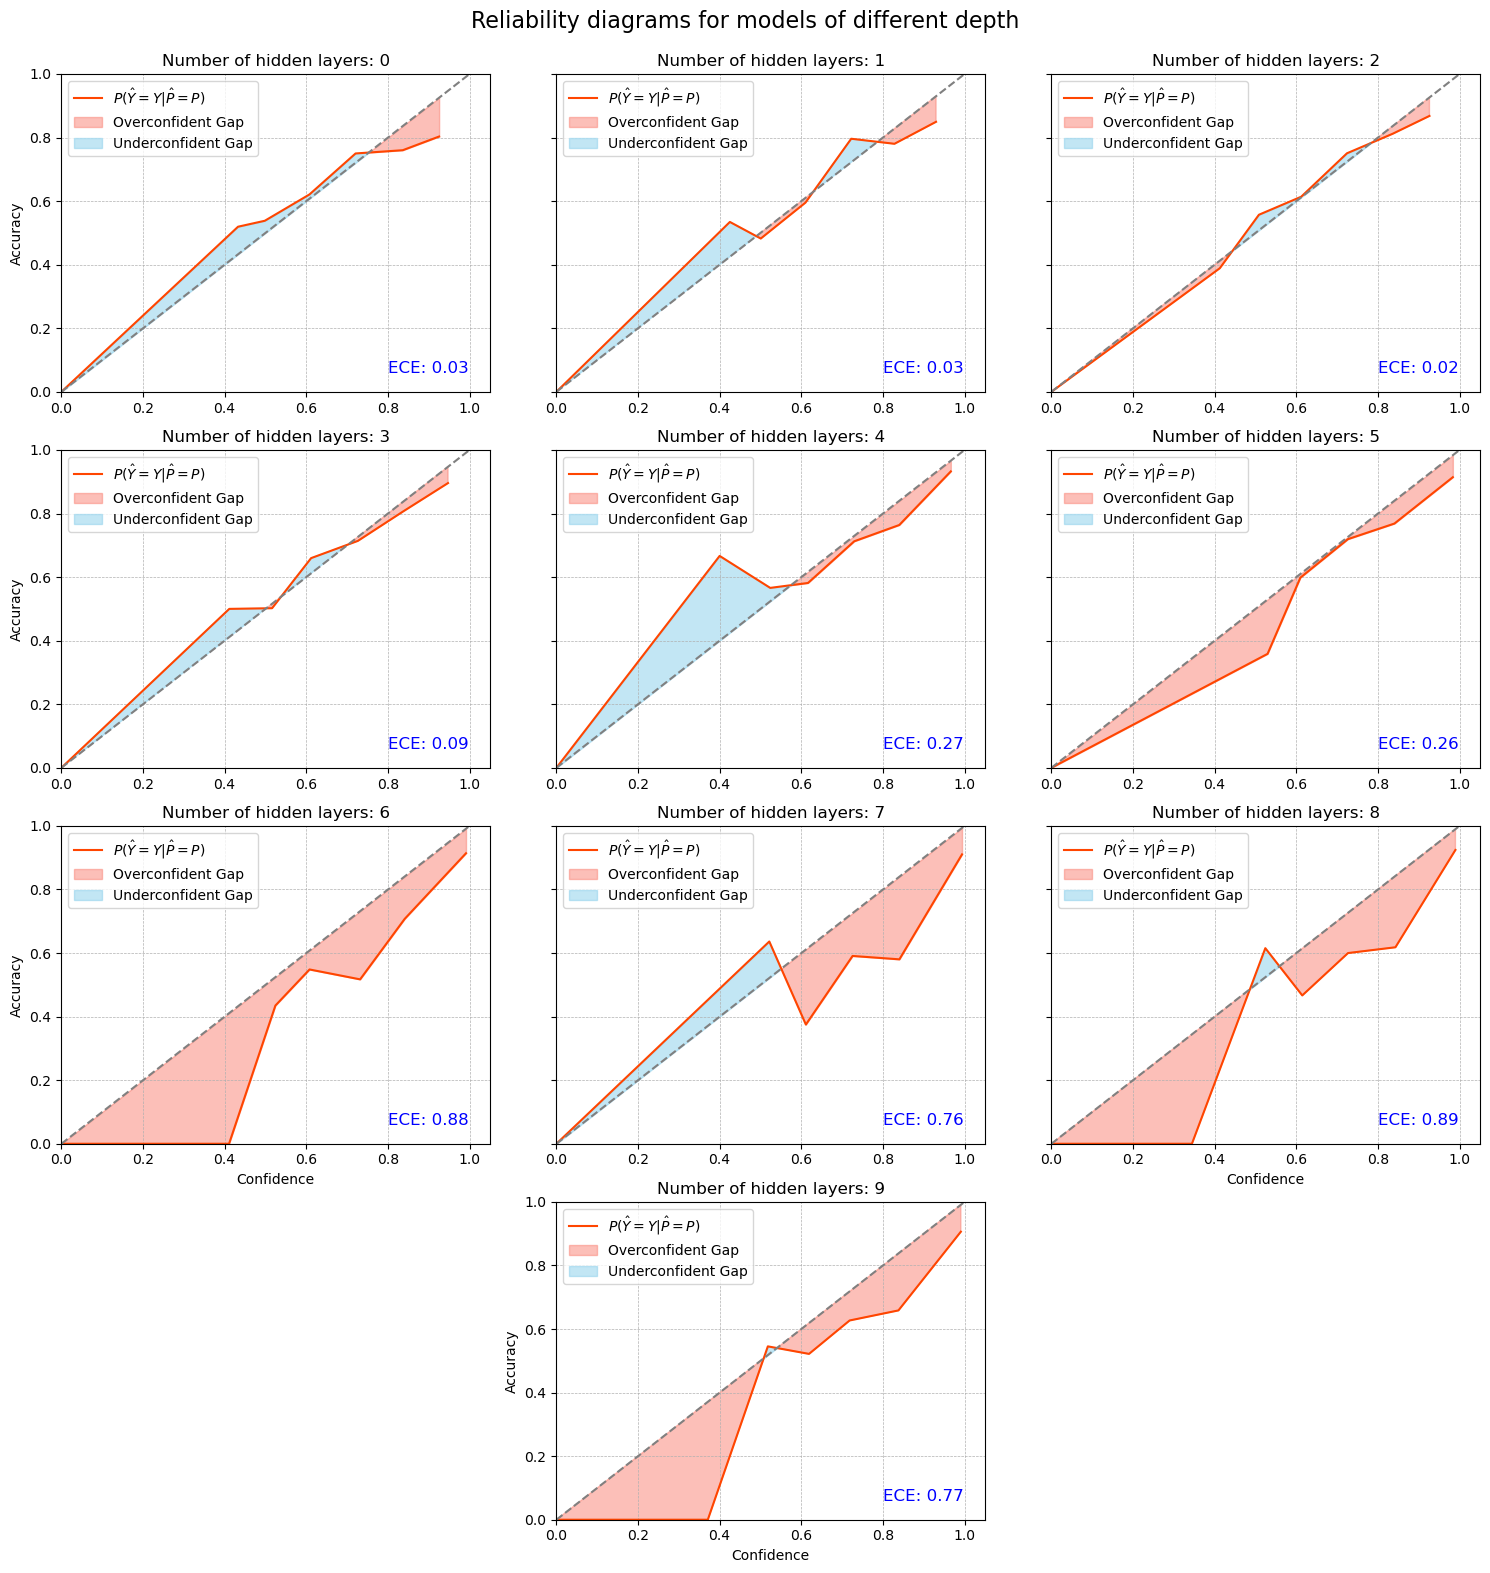

In [106]:
plot_reliability_diagrams(models, X_test, y_test, 10)

🛑 Before moving to the next exercise, answer (in a short sentence) the following question.

**Question**: what does the previous diagrams tell you about the calibration of the neural network?

*Write your answer here.*

### Exercise 4: Expected calibration error, ECE (0.5 points)

For this exercise, you need to compute and print on screen the ECE, which is Eq. (3) from (Guo et al., 2017).

☝ **Hint(s)**: you should have computed almost everything already for Exercise 3. If you have NaN issues, you may want to check for empty bins.

🟩 **Completion requirement**: print the ECE.

In [ ]:
# TODO: compute and print the ECE for the network.

### Exercise 5: Calibrating with the focal loss (1 point)

🟥 Before proceeding, read carefully the following paper: [Calibrating Deep Neural Networks using Focal Loss](https://proceedings.neurips.cc/paper/2020/hash/aeb7b30ef1d024a76f21a1d40e30c302-Abstract.html). We'll refer to it as (Mukhoti et al., 2020).

The task of this exercise is to train again the neural network from before, using the Focal Loss (Section 4 in (Mukhoti et al., 2020)) instead of the cross-entropy:

\begin{equation}
L(y, \hat{y}) = - (1-\hat{y}_c)^\gamma \log \hat{y}_c
\end{equation}

where $\hat{y}$ is the vector of predictions from the network, $c$ is the index of the correct class ($y_c == 1$), $\gamma > 0$ is a hyper-parameter. For $\gamma=0$, this reduces to the cross-entropy.

☝ In order to implement a new loss function in TF, you need to subclass [tf.keras.losses.Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses/Loss). Read carefully the link.

🟩 **Completion requirement**: complete the `FocalLoss` implementation below. Instantiate a new network, train with the new focal loss, and check the resulting confidence histogram, reliability diagram, and ECE.


In [ ]:
class FocalLoss(tf.keras.losses.Loss):
  # TODO: complete implementation

In [ ]:
# TODO: Train a second neural network with the FocalLoss object.

In [ ]:
# TODO: plot confidence histogram, reliability diagram, and print the ECE of the new network.

🛑 Before moving to the next exercise, answer (in a short sentence) the following question.

**Question**: what can you tell about the calibration of this second neural network?

*Write your answer here.*

### Exercise 6: Conformal prediction (1 point)

🟥 Before proceeding, read **Section 1** from the following paper: [A Gentle Introduction to Conformal Prediction and Distribution-Free Uncertainty Quantification](https://arxiv.org/abs/2107.07511). We'll refer to it as (Angelopoulos and Bates, 2021). Note that this material *was not covered in class*.

CP can be understood as an alternative approach to calibration to quantify uncertainty of a model. In CP we take a trained classifier $f(x)$, and we transform it to a set-classifier, i.e., a classifier that outputs a set $\mathcal{C}(x)$ of possible classes. The set is guaranteed to satisfy:

\begin{equation}
P(y \in \mathcal{C}(x)) \ge 1 - \alpha
\end{equation}

where $\alpha$ is a hyper-parameter called the **error rate**, i.e., the probability that the correct class is inside the set is $1-\alpha$. For the purpose of this exercise, you need to implement a simple CP procedure which is described in Fig. 2 of (Angelopoulos and Bates, 2021).

☝ **Hints**: In practice, you would need a separate validation set. For the purpose of this exercise, you can use the previously defined test set for everything. For computing the **quantile**, you are allowed to use NumPy or TensorFlow Probability.

🟩 **Completion requirement**: Replicate the pseudocode from Fig. 2 of (Angelopoulos and Bates, 2021) in TF and apply it on the trained neural network. Plot a histogram showing the distribution of the sizes of the output sets, when the network is run on the entire test set.

In [ ]:
# Implement the CP procedure

In [ ]:
# Plot a histogram of the size of the output set (e.g., check "Set size" on page 12 of (Angelopoulos and Bates, 2021)).

### Final checklist

1. Carefully check all code. Insert comments when needed. Search for "TODO" to see if you forgot something.
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Upload the completed notebook **before 14/11/2022 23:59** on the Google Classrom page.

### References

[1] Guo, C., Pleiss, G., Sun, Y. and Weinberger, K.Q., 2017. [On calibration of modern neural networks](https://arxiv.org/abs/1706.04599). In *ICML* (pp. 1321-1330). PMLR.

[2] Mukhoti, J., Kulharia, V., Sanyal, A., Golodetz, S., Torr, P. and Dokania, P., 2020. [Calibrating deep neural networks using focal loss](https://proceedings.neurips.cc/paper/2020/hash/aeb7b30ef1d024a76f21a1d40e30c302-Abstract.html). In *Advances in Neural Information Processing Systems*, 33, pp. 15288-15299.

[3] Angelopoulos, A.N. and Bates, S., 2021. [A gentle introduction to conformal prediction and distribution-free uncertainty quantification](https://arxiv.org/abs/2107.07511). *arXiv preprint arXiv:2107.07511*.